# ROBO TURBOSKY
The **NUMBER ONE** HELICOPTER WORKING FOR DINOCO!

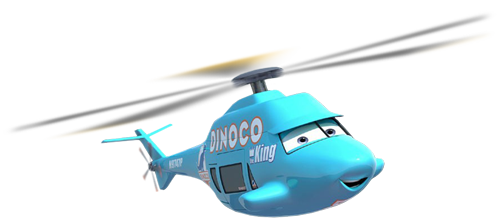

In [9]:
import torch as t
import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import data_manager

from torch.utils.data import DataLoader

In [10]:
class RoboTurbosky(t.nn.Module):
    #some sort of CNN
    #like the news company
    def __init__(self, config):
        super().__init__()

        self.cnn = t.nn.Sequential(
            t.nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1),
            t.nn.ReLU(),
            t.nn.MaxPool2d(2),
            t.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            t.nn.ReLU(),
            t.nn.MaxPool2d(2),
            t.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            t.nn.ReLU(),
            t.nn.AdaptiveAvgPool2d((1,1)),
            t.nn.Flatten()
        )

        self.coord = t.nn.Sequential(
            t.nn.Linear(2, 32),
            t.nn.ReLU(),
            t.nn.Linear(32, 64),
            t.nn.ReLU()
        )

        self.combined = t.nn.Sequential(
            t.nn.Linear(192, 256),
            t.nn.ReLU()
        )

        #x, z
        self.position_head = t.nn.Sequential(
            t.nn.Linear(256 + 3, 128),
            t.nn.ReLU(),
            t.nn.Linear(128, 2)
        )

        #speed, gas, brake,
        self.control_head = t.nn.Sequential(
            t.nn.Linear(256, 128),
            t.nn.ReLU(),
            t.nn.Linear(128, 3)
        )

    def forward(self, patch, coord):
        x_patch = self.cnn(patch)
        x_coord = self.coord(coord)
        x = t.cat([x_patch, x_coord], dim=1)
        x_combined = self.combined(x)

        control = self.control_head(x_combined)
        pos_in = t.cat([x_combined, control], dim=1)
        position = self.position_head(pos_in)
        #position = self.position_head(t.cat([x_combined, control], dim=1))

        return control, position


In [11]:
class PositionLoss(t.nn.Module):
    def __init__(self, weight=1.0):
        super(PositionLoss, self).__init__()
        self.mse_loss = t.nn.MSELoss()

    def forward(self, predicted, targets):
        loss = self.mse_loss(predicted, targets["ai_norm"])
        return loss

#we can add penalties to encourage smoother and more realistic driving here
class ControlLoss(t.nn.Module):
    def __init__(self, weight=1.0):
        super(ControlLoss, self).__init__()
        self.mse_loss = t.nn.MSELoss()
        
    def forward(self, predicted, targets):
        precited_speed = predicted[:, 0]
        predicted_gas = predicted[:, 1]
        predicted_brake = predicted[:, 2]
        
        
        loss = (
            self.mse_loss(precited_speed, targets["ai_cont"][:, 0]) +
            self.mse_loss(predicted_gas, targets["ai_cont"][:, 1]) +
            self.mse_loss(predicted_brake, targets["ai_cont"][:, 2])
        )

        gas_penalty = t.clamp(predicted_gas - 1, min=0) + t.clamp(0 - predicted_gas, min=0)
        brake_penalty = t.clamp(predicted_brake - 1, min=0) + t.clamp(0 - predicted_brake, min=0)

        penalty = 10 * (gas_penalty.pow(2).mean() + brake_penalty.pow(2).mean())

        return loss + penalty

In [12]:
#datasets = TrackDataset("cuda")

In [13]:
# def show_patches(data, number=64):
#     indices = np.random.choice(len(data), number, replace=False)
#     #indices = range(100000,100064)
#     #indices = range(64)


#     images = []
#     xy_dat = []
#     center = []

#     for i in indices:
#         inputs, outputs = data[i]
#         images.append(inputs["patch"])
#         xy_dat.append(outputs["ai_norm"])
#         center.append(inputs["center"])

#     import matplotlib.pyplot as plt

#     grid_size = int(np.ceil(np.sqrt(number)))
#     fix, axes = plt.subplots(grid_size, grid_size, figsize=(10,10))
#     axes = axes.flatten()

#     for i in range(grid_size * grid_size):
#         if i < len(images):
#             axes[i].imshow(images[i].numpy(), cmap='gray')
#             axes[i].plot(xy_dat[i][0::2],xy_dat[i][1::2], 'r.', markersize=5)
#             axes[i].plot(center[i][0::2],center[i][1::2], 'b.', markersize=5)
#             axes[i].set_xlim(0,1024)
#             axes[i].set_ylim(1024,0)
#         else:
#             axes[i].remove()

#     plt.tight_layout()
#     plt.show()


In [14]:
config = {
    #General settings
    "device"       : "cuda",
    #Training Settings
    "epochs"       : 50,
    "learning_rate": 0.0001,
    #Data settings
    "model_save_path" : "./models/protorotorturbosky.pt",
    "dataset_dir"     : "./data/electricboogaloo",
    "split_ratio"     : 0.8,
    "batch_size"      : 64,
    "seed"            : 42,
}

In [15]:
def save_model(model, config, temp_save = None):
    if temp_save is None:
        save_name = config["model_save_path"]
    else:
        save_name = temp_save
    t.save({
        "model_state_dict": model.state_dict(),
        "config": config,
    }, save_name)

In [ ]:
device = config["device"]
model = RoboTurbosky(config)
model.to(device)
pos_crit  = PositionLoss()
cont_crit   = ControlLoss(weight=1.0)
optimizer = t.optim.Adam(model.parameters(), lr=config["learning_rate"])

train, val = data_manager.load_training_dataset(config["dataset_dir"], 
                                                config["device"], 
                                                config["split_ratio"], 
                                                batch_size=config["batch_size"], 
                                                seed=config["seed"])

for epoch in tqdm(range(config["epochs"]), desc="Training Progress"):
    
    dataloader = tqdm(train, desc="Epoch Progress", leave=False)
    for inputs, outputs in dataloader:
        inputs = {k: v.to(device) for k,v in inputs.items()}
        outputs= {k: v.to(device) for k,v in outputs.items()}
        optimizer.zero_grad()
        p_cont, p_pos = model(inputs["patch"].unsqueeze(1), inputs["center"])
        loss =  (
            cont_crit(p_cont, outputs) +
            pos_crit(p_pos, outputs)
        )
        loss.backward()
        optimizer.step()
        dataloader.set_postfix({"Loss" : loss.item()})
    
    save_model(model, config, temp_save = (config["model_save_path"] + "_temp_" + str(epoch)))

Loading Tracks:   0%|          | 0/93 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch Progress:   0%|          | 0/3004 [00:00<?, ?it/s]

TypeError: can only concatenate str (not "int") to str

In [ ]:
save_model(model, config)

In [ ]:
test = data_manager.create_inference_data("./data/amogus.png")
owen = data_manager.create_inference_data("./data/owen.png")

In [ ]:
plt.imshow(test["track_image"], cmap='gray')



In [ ]:
def infer_track(model, track_data):
    patches = t.tensor(np.array(track_data["patches"]), dtype=t.float32).unsqueeze(1).to("cuda")
    center = t.tensor(np.array(track_data["center"]), dtype=t.float32).to("cuda")

    with t.no_grad():
        control, position = model(patches, center)

    return control, position


In [ ]:
a, b = infer_track(spencer, owen)

In [ ]:

b = b.cpu()
a = a.cpu()

from matplotlib.collections import LineCollection

color_val = a[:,1] - a[:,2]
print(color_val.min())
print(color_val.max())
norm = plt.Normalize(vmin=color_val.min(), vmax=color_val.max())
points = b.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap='turbo', norm=norm)
lc.set_array(color_val[:-1])
lc.set_linewidth(1)

fig, ax = plt.subplots(figsize=(12,8))
ax.add_collection(lc)

plt.imshow(owen["track_image"], cmap="gray")
plt.colorbar(lc, ax=ax, label="gas-brake")
#plt.plot(b[:,0], b[:,1], linestyle=":", linewidth=2)
plt.show()

#norm_speed = plt.Normalize(vmin=a[:,0].min(), vmax=a[:,0].max())
lc_speed = LineCollection(segments, cmap="viridis")#, norm=norm_speed)
lc_speed.set_array(a[:,0])
lc_speed.set_linewidth(1)

fix, ax = plt.subplots(figsize=(12,8))
plt.imshow(owen["track_image"], cmap="gray")
ax.add_collection(lc_speed)
plt.colorbar(lc_speed, ax=ax, label="Speed")
plt.show()




In [ ]:
p